In [1]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nv-group01\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nv-group01\.qcodes\logs\240607-10320-qcodes.log


## Coherent Control and Rabi Oscillations

For this experiment, we shall choose one of the many resonance frequencies that were observed in the ODMR spectra at a suitable magnetic field. Similar to the ODMR experiment, the microwave source will need to be programmed to output an oscillating signal with the chosen resonance frequency. Enter the resonance frequency below, choose the peak with the lowest frequency.

In [2]:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')

microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')
microwave_src.IQ_modulation('EXT')

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(0.8)

pulse_blaster.stop()

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.33s
Connected to: ANRITSU MG3681A (serial:6100146424, firmware:3.03) in 0.17s
Connected to: KORAD KD3005P V6.7 SN 48562561 (serial:None, firmware:None) in 0.06s


0

In [3]:
#Use this to make a parameter out of anything!
MW_on_time= qc.ManualParameter('Pulselength', unit='s')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "Coherent Control.db")
experiment = load_or_create_experiment(
    experiment_name='Coherent Control',
    sample_name=""
)

meas = Measurement(exp=experiment, name='Coherent Control')
meas.register_parameter(MW_on_time)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent one

In [4]:
# #Stop the pulse blaster so that we can let the states equilibriate and then sweep after initializing.
# pulse_blaster.stop()
# microwave_src.output('OFF')


# tau_0 =  100e-6    #starting tau in seconds
# tau_f =  100e-9   #Ending tau in seconds
# stepsize = 0.0005  #stepsize in seconds

# T_pulse_i = 0.1e-6
# T_pulse_f = 3e-6

# ref_f = 21
# ref_D = 0.5
# T_ref_on = ref_D/ref_f
# T_ref_off = (1 - ref_D)/ref_f

# laser_f = 100e3                                   #Laser modulation frequency.
# laser_D = 0.3                                        #Laser modulation duty cycle.
# T_laser_on = laser_D/laser_f                #Laser on time. 
# T_laser_off = (1 - laser_D)/laser_f         #Laser off time.
# N_laser_pulses = round(laser_f/ref_f)           #Number of laser pulses that can fit in the reference period.

# T_mw_off =  laser_D/laser_f
# N_mw_pulses = round(laser_f/(ref_f*2))             #Number of microwave pulses that can fit in the reference period.
# T_mw_on = (1 - laser_D)/laser_f                       #Microwave time on.


# T_laser_on = 500e-6 #Chosen for signal resolution, as we are only doing 1 experiment under the reference for a long reference time.
# T_laser_off = 1/(2*ref_f) - T_laser_on #500e-6
# def T_idle(tau):
#     return 1/(2*ref_f) - (2*T_laser_on + tau)
# # #TODO: Write the required wait time as a function of tau.
# # lock_in_amp.time_constant(3)#time constant here)
# # lock_in_amp.sensitivity(10e-3)#sensativity here)

# def T1_PP(T_pulse, tau = tau_f):
#     pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
#     pulse_blaster.ch0.pulse_sequence_buffer.set(
#         [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
#     )                                     #Define the new pulse sequence for channel 0.
#     pulse_blaster.ch1.pulse_sequence_buffer.set(
#         [pulse(level=1, duration=T_laser_on), pulse(level=0, duration=2*tau + T_pulse), 
#          pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_ref_on - 2*T_laser_on - (2*tau + T_pulse)),
#          pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_ref_on - T_laser_on)]
#     )                                     #Define the new pulse sequence for channel 1.
#     pulse_blaster.ch2.pulse_sequence_buffer.set(
#         [pulse(level=0, duration=T_laser_on + tau), pulse(level=1, duration=T_pulse), 
#          pulse(level=0, duration=2*T_ref_on - T_pulse - T_laser_on - tau)]
#     )         

# T1_PP(T_pulse_f, tau=tau_f)
# pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.

In [4]:
ref_f = 200
ref_D = 0.5
T_ref_on = ref_D/ref_f
T_ref_off = (1 - ref_D)/ref_f

laser_f = 100e3                                 #Laser modulation frequency.
laser_D = 0.3                                   #Laser modulation duty cycle.
T_laser_on = laser_D/laser_f                    #Laser on time. 
T_laser_off = (1 - laser_D)/laser_f             #Laser off time.
N_laser_pulses = round(laser_f/ref_f)           #Number of laser pulses that can fit in the reference period.

T_mw_off =  laser_D/laser_f
N_mw_pulses = round(laser_f/(ref_f*2))          #Number of microwave pulses that can fit in the reference period.
T_mw_on = (1 - laser_D)/laser_f                 #Microwave time on.

In [11]:
T_ref_on

0.0025

In [40]:
delta_tau_ref - tau_mw - tau_padding_right - T_laser_on

NameError: name 'delta_tau_ref' is not defined

In [58]:
Rabi_Osc_PP(10e-6)

2.3333333333333336e-06 1e-06 1e-05 3.3333333333333333e-06


1.1333333333333332e-05 1e-06 1e-06 3.3333333333333333e-06


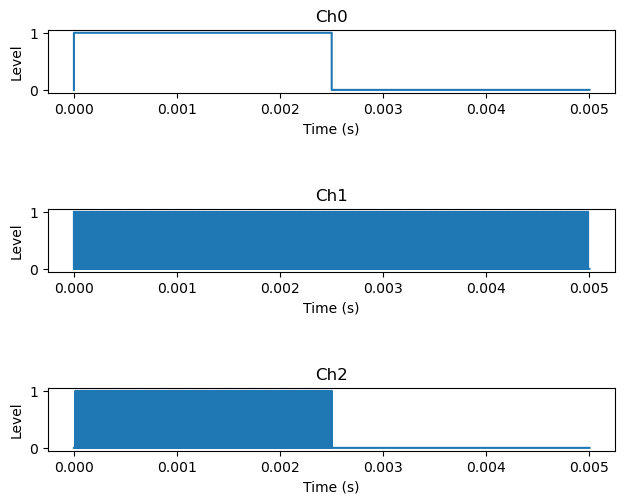

In [79]:
lock_in_amp.time_constant(3)#Your time constant here)
lock_in_amp.sensitivity(100e-12)#Your sensitivity here)
microwave_src.power(-15)#Your power here) #<= 15
microwave_src.frequency(2711557788.94472)#Chosen frequency here)

ratio = 5
tau_padding_right = 1e-6
N_mw_pulses = 150

def Rabi_Osc_PP(tau_mw):
    
    N_laser_pulses = 2*N_mw_pulses
    delta_tau_ref = T_ref_on/N_mw_pulses
    T_laser_on = delta_tau_ref / ratio
    T_laser_off = delta_tau_ref - T_laser_on
    tau_padding_left = delta_tau_ref - tau_mw - tau_padding_right - T_laser_on
    print(tau_padding_left, tau_padding_right, tau_mw, T_laser_on)
    assert(tau_padding_left >= 0)
    
    pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
    )
    
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        [[pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_laser_off)] for i in range(0, N_laser_pulses)] 
    )                                     #Define the new pulse sequence for channel 1.
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        [[pulse(level=0, duration=T_laser_on+tau_padding_left), pulse(level=1, duration= tau_mw),  pulse(level=0, duration=tau_padding_right)] for i in range(0, N_mw_pulses)] +
        [pulse(level=0, duration=float(T_ref_off))]
    ) 

T_mw_on_examp = 1e-6
Rabi_Osc_PP(T_mw_on_examp)
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.
pulse_blaster.flush_channel_buffer()

Starting experimental run with id: 24. 
0
2e-08
1.2313333333333333e-05 1e-06 2e-08 3.3333333333333333e-06
1
1.0122448979591838e-07
1.2232108843537415e-05 1e-06 1.0122448979591838e-07 3.3333333333333333e-06
2
1.8244897959183674e-07
1.2150884353741496e-05 1e-06 1.8244897959183674e-07 3.3333333333333333e-06
3
2.6367346938775513e-07
1.2069659863945578e-05 1e-06 2.6367346938775513e-07 3.3333333333333333e-06
4
3.448979591836735e-07
1.198843537414966e-05 1e-06 3.448979591836735e-07 3.3333333333333333e-06
5
4.261224489795919e-07
1.1907210884353741e-05 1e-06 4.261224489795919e-07 3.3333333333333333e-06
6
5.073469387755102e-07
1.1825986394557823e-05 1e-06 5.073469387755102e-07 3.3333333333333333e-06
7
5.885714285714286e-07
1.1744761904761905e-05 1e-06 5.885714285714286e-07 3.3333333333333333e-06
8
6.69795918367347e-07
1.1663537414965987e-05 1e-06 6.69795918367347e-07 3.3333333333333333e-06
9
7.510204081632654e-07
1.1582312925170068e-05 1e-06 7.510204081632654e-07 3.3333333333333333e-06
10
8.3224

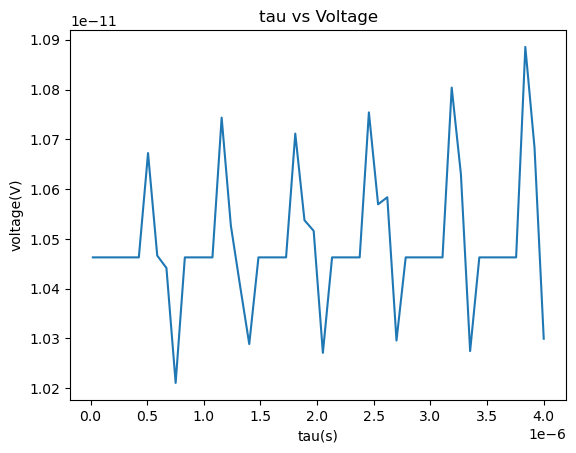

In [80]:
tau_mw_i = 20e-9
tau_mw_f = 4e-6
steps = 50
tau_arr = np.linspace(tau_mw_i, tau_mw_f, steps)

#Microwave needs to be off, so this is just to be sure it is.
with meas.run() as datasaver:
   # for i in list(range(0, int((tau_mw_f - tau_mw_i)/stepsize))):
    for i in range(tau_arr.size):
        print(i)
        #Reinitialize the pulse sequence with the new tau.
        #This is a good approach to initializing a new pulse sequence in a loop.
        tau_mw = tau_arr[i]
        print(tau_mw)
        Rabi_Osc_PP(tau_mw)
        pulse_blaster.flush_channel_buffer()
        #For getting your first data point with a new sequence, it helps to give the LIA more time to settle to drastic changes in input data.
        if i == 0:
            sleep(10*lock_in_amp.time_constant())
        else:
            sleep(5*lock_in_amp.time_constant())
        # sleep(1)
        ###############################
        #Specify the data being saved below 
        datasaver.add_result((MW_on_time, tau_mw),
                             (LI_R, lock_in_amp.R()))
        ###############################

    T1 = datasaver.dataset  # convenient to have for data access and plotting
   
pulse_blaster.stop()
T1_data = T1.to_pandas_dataframe()
plt.plot(T1_data["Pulselength"], T1_data["Signal"])
plt.xlabel('tau(s)')
plt.ylabel('voltage(V)')
plt.title('tau vs Voltage')
plt.show()

In [81]:
T1_data.to_csv("rabi_test_3.csv")

In [73]:
import pandas as pd

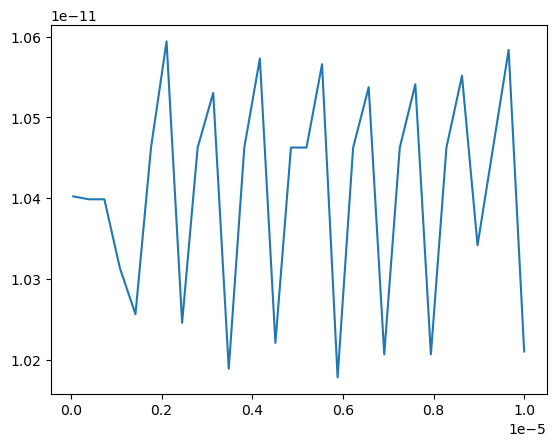

In [77]:
plt.plot(pd.read_csv("rabi_test_1.csv")["Pulselength"], pd.read_csv("rabi_test_1.csv")["Signal"])

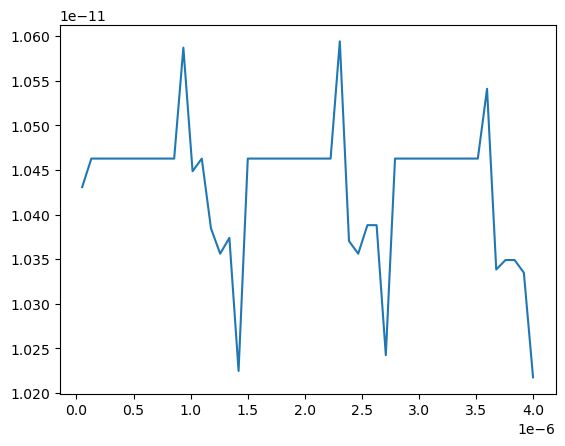

In [78]:
plt.plot(pd.read_csv("rabi_test_2.csv")["Pulselength"], pd.read_csv("rabi_test_2.csv")["Signal"])

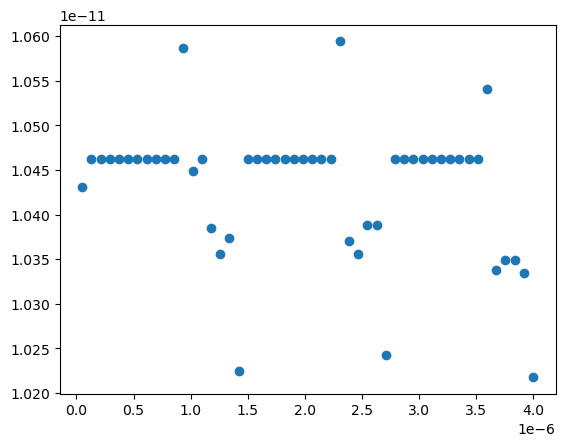

In [69]:
plt.plot(T1_data['Pulselength'], T1_data['Signal'])

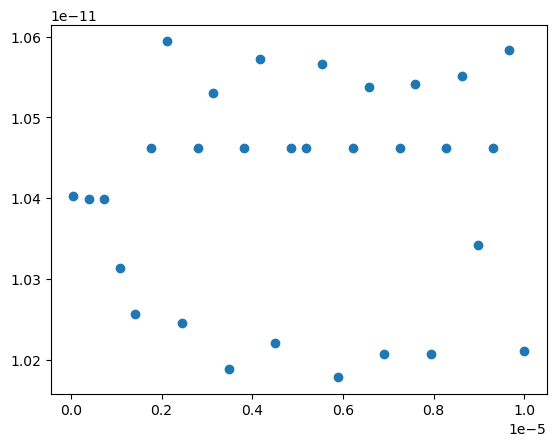

In [65]:
plt.scatter(T1_data['Pulselength'], T1_data['Signal'])

Starting experimental run with id: 9. 
5e-08
0.00019994000000000004 1e-08 5e-08 5e-05
1.5555555555555554e-07
0.00019983444444444446 1e-08 1.5555555555555554e-07 5e-05
2.6111111111111113e-07
0.00019972888888888888 1e-08 2.6111111111111113e-07 5e-05
3.6666666666666667e-07
0.00019962333333333336 1e-08 3.6666666666666667e-07 5e-05
4.722222222222222e-07
0.00019951777777777778 1e-08 4.722222222222222e-07 5e-05
5.777777777777778e-07
0.00019941222222222225 1e-08 5.777777777777778e-07 5e-05
6.833333333333333e-07
0.00019930666666666667 1e-08 6.833333333333333e-07 5e-05
7.888888888888888e-07
0.00019920111111111115 1e-08 7.888888888888888e-07 5e-05
8.944444444444445e-07
0.00019909555555555557 1e-08 8.944444444444445e-07 5e-05
1e-06
0.00019899 1e-08 1e-06 5e-05


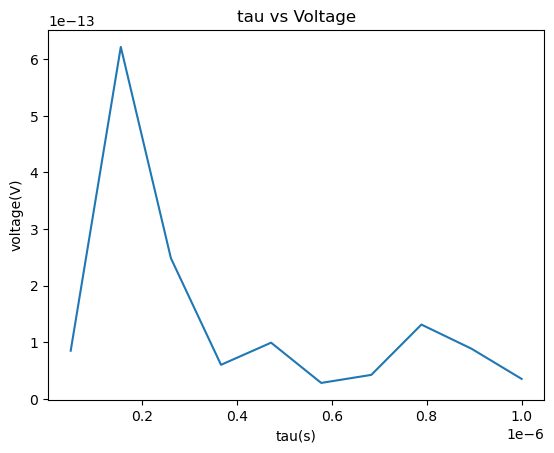

In [8]:
tau_mw_i = 50e-9
tau_mw_f = 1e-6
steps = 10
tau_arr = np.linspace(tau_mw_i, tau_mw_f, steps)

#Microwave needs to be off, so this is just to be sure it is.
with meas.run() as datasaver:
   # for i in list(range(0, int((tau_mw_f - tau_mw_i)/stepsize))):
    for i in range(tau_arr.size):
        #Reinitialize the pulse sequence with the new tau.
        #This is a good approach to initializing a new pulse sequence in a loop.
        tau_mw = tau_arr[i]
        print(tau_mw)
        Rabi_Osc_PP(tau_mw)
        pulse_blaster.flush_channel_buffer()
        #For getting your first data point with a new sequence, it helps to give the LIA more time to settle to drastic changes in input data.
        if i == 0:
            sleep(16*lock_in_amp.time_constant())
        else:
            sleep(8*lock_in_amp.time_constant())
        ###############################
        #Specify the data being saved below 
        datasaver.add_result((MW_on_time, tau_mw),
                             (LI_R, lock_in_amp.R()))
        ###############################

    T1 = datasaver.dataset  # convenient to have for data access and plotting
   
pulse_blaster.stop()
T1_data = T1.to_pandas_dataframe()
plt.plot(T1_data["Pulselength"], T1_data["Signal"])
plt.xlabel('tau(s)')
plt.ylabel('voltage(V)')
plt.title('tau vs Voltage')
plt.show()

In [ ]:
def get_T_mw_off(mw_on_time):
    return #Your microwave off time determination code here
N_mw_pulses =                     #Number of microwave pulses that can fit in the reference period.

T_padding = 6e-6


#Potentially useful set of test conditions for diagnosing misprogramming issues.
print(1e6*T_ref_on, 1e6*T_ref_off)
print(1e6*T_laser_on, 1e6*T_laser_off, N_laser_pulses)
print(1e6*get_T_mw_off(T_mw_on_examp), 1e6*T_mw_on_examp, 1e6*T_padding, N_mw_pulses)

def Rabi_Osc_PP(t_mw_on):
    pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        #TODO: Enter the lock in reference frequency pulse sequence here.
        
    )                                     #Define the new pulse sequence for channel 0.
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        #TODO: Enter the laser pulse sequencea here.
        
    )                                     #Define the new pulse sequence for channel 1.
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        #TODO: Enter the microwave modulation pulse sequence here.
        
    )                                     #Define the new pulse sequence for channel 2.
T_mw_on_examp = 1e-6
Rabi_Osc_PP(T_mw_on_examp)
pulse_blaster.plot_channel_buffer()   #This function plots the newly defined pulse sequence.

In [ ]:
lock_in_amp.time_constant(#Your time constant here)
lock_in_amp.sensitivity(#Your sensitivity here)

dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(#Your current here)

#TODO: Chose microwave on stepsize, min, and maximum values for the experiment.
min_mw_on =                   #Minimum frequency for the spectrum
max_mw_on =                   #Maximum frequency for the spectrum,
mw_on_stepsize =              #Time increase at each step

Set the microwave power to 15 dBm. You will repeat this measurement for microwave powers of 12 dBm, 9 dBm, and 6 dBm.

In [ ]:
microwave_src.output('ON')
microwave_src.power(#Your power here)
with meas.run() as datasaver:
    ###########################
    #Your experiment code here
    
    ###########################
    Rabi = datasaver.dataset  # convenient to have for data access and plotting

Write data analysis code to fit the data and determine the Rabi frequency.

In [ ]:
#TODO: Enter the initial fit params
initial_fit_params =  [#Your initial fit parameters]     #[a, T, f_R, phi, c]
def fit_model(x, a, b, f, p ,c):
    return a * np.exp(-1.0 * x / b) * np.sin(2 * np.pi * f * x + p) + c

## Note:
For lab 3, you will need to use this template to determine the $\pi$ and $\pi/2$ pulselengths for X and Y rotation gates using Rabi oscillations at a given power. The section below can be done during either the lab 2 or lab 3 session: